# HAR (human activity recognition) using DNN/DL on fNIRS data

In [1]:
% ls /home/arasdar/datasets/fNIRs-data-10subjects/

P11-4-17-2018/  P13-4-17-2018/  P15-4-18-2018/  P17-4-18-2018/  P19-4-19-2018/
P12-4-17-2018/  P14-4-18-2018/  P16-4-18-2018/  P18-4-19-2018/  P20-4-19-2018/


In [2]:
% ls /home/arasdar/datasets/fNIRs-data-10subjects/P12-4-17-2018/

1. Right Hand/  2. Both Hands/  3. Left Hand/  4. Right Leg/  5. Left Leg/


In [3]:
% ls /home/arasdar/datasets/fNIRs-data-10subjects/P12-4-17-2018/1.\ Right\ Hand

2018-04-17_006/
fNIR_data.txt
head20180417-145130.txt
NIRS-2018-04-17_006_deoxyhb_T141to2511_C1to20.txt
NIRS-2018-04-17_006_oxyhb_T141to2511_C1to20.txt
Processed/
r_hand20180417-145128.txt
r_lower_arm20180417-145129.txt
r_upper_arm20180417-145129.txt


In [4]:
import numpy as np
import os
import pandas as pd

# % find ../../datasets/fNIRs_data/ | grep fNIR_data # NOT WORKING!!
def find_all(name, path):
    result = []
    for root, dirs, files in os.walk(path):
        if name in files:
            result.append(os.path.join(root, name))
    return result

allpaths = find_all(name='fNIR_data.txt', path='/home/arasdar/datasets/fNIRs-data-10subjects/')
allpaths = sorted(allpaths, reverse=False)
# print(allpaths, len(allpaths))
# allpaths, len(allpaths)

In [5]:
# df: data frame object
df = []
for each_idx in range(len(allpaths)):
    file = pd.read_csv(filepath_or_buffer=allpaths[each_idx], names=['time', 'sample', 
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel'],
                         header=None)
    df.append(file)
    
for each in range(len(df)):
#     print(df[each].shape, allpaths[each])
    df[each]=df[each].drop(axis=1, columns=None, index=None, labels=['time', 'sample'])
    df[each] = df[each].dropna()
    df[each]['channel.39'] = df[each]['channel.39'].astype(str).str[1:-1].astype(float)
# print(len(df))

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/pandas/io/parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [6]:
data, labels = [], []
for each in range(0, len(df), 1):
    dfmat = df[each].as_matrix()
    label = allpaths[each][59:60]
#     print(dfmat.dtype, dfmat.shape, label, allpaths[each])
    data.append(dfmat)
    labels.append(label)
len(data), len(labels)

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(48, 48)

In [7]:
# This is very much like a convolution for extracting the windows
# size/width, stride/overlap, padding, dilation, num filters/out channel
def minibatching(X, Y, stride, width):
    Xmb, Ymb = [], []
    print(len(X), len(Y))
    # 1st and 1st
    for eachX in range(len(X)):
        num_mb = ((X[eachX].shape[0]-width)//stride)+1
        for each in range(num_mb):
            # The max is (num_mb-1)*stride+width==X[idx].shape[0]
            # The last each is (num_mb-1)
            # each = ((each-1)*stride)+width
            each *= stride
            Xmb.append(X[eachX][each:each+width])
            # There is only one label for one image signal or signal window or temporal window
            #Ymb.append(Y[eachX][each:each+1])
            Ymb.append(Y[eachX])
    return Xmb, Ymb

In [8]:
# Width is based on the sampling rate which is roughly about 233 points per window
# for 10sec rest and 20 sec activity
width = 250
Xmb, Ymb = minibatching(X=data, Y=labels, stride=1, width=width)
# for eachX, eachY in zip(Xmb, Ymb):
#     print(eachX.shape, eachY)
print(len(Xmb), len(Ymb))
print(Xmb[0].shape, Xmb[0].dtype)
print(Ymb[0])

48 48
69615 69615
(250, 40) float64
1


In [9]:
# Conversion from python list to numpy array
X, Y=np.array(object=Xmb, dtype=float), np.array(object=Ymb, dtype=int)
print(X.shape, X.dtype, Y.shape, Y.dtype)

(69615, 250, 40) float64 (69615,) int64


In [10]:
# Now I should devide the data into train and test
# Train and valid split
from sklearn.model_selection import train_test_split

# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.30)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)
print(Xtrain.dtype, Xtest.dtype, Ytrain.dtype, Ytest.dtype)

(48730, 250, 40) (20885, 250, 40) (48730,) (20885,)
float64 float64 int64 int64


In [11]:
# # # standardizing/normalizing the train and test data
# # def standardize(train, test):
# # """ Standardize data """
# # # Standardize train and test
# # X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
# # X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]
# # return X_train, X_test

# Xtrain = (Xtrain - Xtrain.mean(axis=0))/ Xtrain.std(axis=0)
# Xtest = (Xtest - Xtest.mean(axis=0))/ Xtest.std(axis=0)
# print(Xtrain.shape, Xtrain.dtype)
# print(Xtest.shape, Xtest.dtype)

In [12]:
print(Xtrain.mean(axis=0), Xtrain.std(axis=0))

[[0.23560809 0.20590258 0.18517964 ... 0.46093329 0.5279274  0.49592215]
 [0.23561636 0.2058755  0.18519695 ... 0.46097109 0.52793335 0.49596181]
 [0.23563596 0.20587837 0.18519753 ... 0.46093337 0.52789045 0.49594298]
 ...
 [0.23555652 0.20642326 0.18566778 ... 0.46190655 0.52917613 0.49877004]
 [0.23553725 0.20641371 0.18569792 ... 0.46184699 0.52914537 0.49875218]
 [0.23553967 0.2064045  0.18566768 ... 0.46187172 0.52917467 0.49876183]] [[0.19317671 0.16669308 0.22277043 ... 0.42603084 0.32873045 0.3955654 ]
 [0.19313845 0.16665441 0.22276896 ... 0.42603955 0.32870983 0.39565034]
 [0.1931707  0.16667711 0.22273841 ... 0.42604402 0.32865582 0.39566495]
 ...
 [0.1937856  0.16681899 0.22340253 ... 0.42544458 0.33035244 0.39905449]
 [0.19376731 0.1668185  0.22342971 ... 0.42545467 0.33032835 0.39903573]
 [0.19377306 0.16687328 0.22346157 ... 0.42542825 0.33035364 0.39903639]]


In [13]:
print(Xtest.mean(axis=0), Xtest.std(axis=0))

[[0.23750688 0.20563448 0.18284557 ... 0.4569635  0.52787929 0.49390254]
 [0.2374863  0.20570345 0.18281442 ... 0.45689085 0.52786907 0.49384319]
 [0.23743777 0.20570397 0.1828217  ... 0.45699592 0.52796656 0.49392436]
 ...
 [0.23746366 0.20622423 0.18329864 ... 0.45778139 0.52898759 0.49654501]
 [0.2375106  0.20625165 0.18323827 ... 0.4579245  0.52907577 0.49659166]
 [0.23751252 0.20628102 0.18331419 ... 0.45787678 0.52901634 0.49657356]] [[0.19255126 0.16571486 0.2190757  ... 0.41900629 0.33053152 0.3915767 ]
 [0.19264678 0.16579607 0.2190893  ... 0.41899054 0.33058174 0.39144025]
 [0.1925735  0.16573736 0.21917049 ... 0.4189778  0.33069999 0.39147301]
 ...
 [0.19336617 0.16587925 0.2198813  ... 0.41863321 0.33208232 0.39478377]
 [0.19340748 0.16588515 0.21981469 ... 0.41861174 0.33216975 0.39483916]
 [0.19340226 0.16576797 0.21974963 ... 0.4186778  0.33213945 0.39484852]]


In [14]:
# Now separating train and validation set
# 30% of the training data/ entire training data is assigned to validation.
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtrain, Ytrain, test_size=0.30)
print(Xtrain.shape, Xvalid.shape, Xtest.shape, Xtrain.dtype, Xvalid.dtype, Xtest.dtype)
print(Ytrain.shape, Yvalid.shape, Ytest.shape, Ytrain.dtype, Yvalid.dtype, Ytest.dtype)

(34111, 250, 40) (14619, 250, 40) (20885, 250, 40) float64 float64 float64
(34111,) (14619,) (20885,) int64 int64 int64


In [15]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


In [16]:
def model_input(input_size, output_size):
    #     N, W, Cin = Xvalid.shape[0], Xvalid.shape[1], Xvalid.shape[2]
    Xinputs = tf.placeholder(dtype=tf.float32, shape=[None, *input_size], name='Xinputs')
    
    #     N, Cout = Yvalid.shape[0], Yvalid.shape[1]
    Yindices = tf.placeholder(dtype=tf.int32, shape=[None], name='Yindices')
    
    # # Batchnorm mode: training and inference/testing/validation
    # #is_bn_training = tf.placeholder(dtype=tf.bool, shape=[], name='is_bn_training')
    # training = tf.placeholder(dtype=tf.bool, shape=[], name='training')

    # returning input data/sequences, output labels/classes
    return Xinputs, Yindices

In [18]:
# Discriminator/ classifier/ recognizer
def discriminator(Xinputs, input_size, output_size, hidden_size, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Flatten/Vectorize the input data tensor for FC/fully connected layer/Dense Layer
        Xinputs_vec = tf.reshape(tensor=Xinputs, shape=[-1, input_size[0]*input_size[1]])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=Xinputs_vec, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=output_size)   
        #predictions = tf.nn.softmax(logits)
        
        # return output logits for loss and accuracy
        return logits

In [19]:
# # Discriminator/ classifier/ recognizer
# def discriminator(Xinputs, input_size, output_size, hidden_size, reuse=False, alpha=0.1, training=True):
#     with tf.variable_scope('discriminator', reuse=reuse):
        
#         # Flatten/Vectorize the input data tensor for FC/fully connected layer/Dense Layer
#         Xinputs_vec = tf.reshape(tensor=Xinputs, shape=[-1, input_size[0]*input_size[1]])
        
#         # First fully connected layer
#         h1 = tf.layers.dense(inputs=Xinputs_vec, units=hidden_size)
#         nl1 = tf.maximum(alpha * h1, h1)
        
#         # Second fully connected layer
#         h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
#         nl2 = tf.maximum(alpha * h2, h2)
        
#         # Output layer
#         logits = tf.layers.dense(inputs=nl2, units=output_size)   
#         #predictions = tf.nn.softmax(logits)
        
#         # return output logits for loss and accuracy
#         return logits

In [20]:
# This is the forward propagation of the model to calculate the loss.
def model_loss(Xinputs, Yindices, input_size, output_size, hidden_size):
    
    # Creating logits and labels
    Ylogits = discriminator(Xinputs=Xinputs, input_size=input_size, output_size=output_size, 
                            hidden_size=hidden_size)
    Ylabels = tf.one_hot(indices=Yindices, depth=output_size, dtype=Ylogits.dtype)
    
    # Loss using logits and labels
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Ylabels))
    
    # Accuracy using logits and labels
    acc_tensor = tf.equal(x=tf.argmax(axis=1, input=Ylogits), y=tf.argmax(axis=1, input=Ylabels))
    acc = tf.reduce_mean(axis=0, input_tensor=tf.cast(dtype=tf.float32, x=acc_tensor))

    # returning loss and accuracy
    return loss, acc

In [21]:
# def model_opt(loss, learning_rate):
#     """
#     Get optimization operations in order
#     :param loss: Discriminator/classifier loss Tensor
#     :param learning_rate: Learning Rate Placeholder
#     :return: A tuple of (discriminator training)
#     """
#     # Get weights and bias to update
#     t_vars = tf.trainable_variables()
#     # q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
#     # g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
#     # d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt
#     var_list = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt
    
#     # Optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         # q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
#         # g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
#         # d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
#         opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=var_list)

#     return opt

In [22]:
class MLP:
    def __init__(self, input_size, output_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.Xinputs, self.Yindices = model_input(input_size=input_size, output_size=output_size)

        # Create the Model: calculating the loss and forwad pass
        self.loss, self.acc = model_loss(Xinputs=self.Xinputs, Yindices=self.Yindices,
                                         input_size=input_size, output_size=output_size, hidden_size=hidden_size)

        # Update the model: backward pass and backprop
        #self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [23]:
def get_batches(X, Y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, Y = X[:n_batches*batch_size], Y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], Y[b:b+batch_size]

In [24]:
# Network Hyper-parameters

# # Input
# Xwidth, Xchannels = Xvalid.shape[1], Xvalid.shape[2]

# Output layer
assert Ytrain.max()==Ytest.max()==Yvalid.max(), 'Output classes'
# Ychannels = Yvalid.max()

# Hidden layer
input_size = [Xvalid.shape[1], Xvalid.shape[2]]
hidden_size = Xvalid.shape[1]* Xvalid.shape[2]
output_size = Yvalid.max()

# learning parameters
batch_size = Xvalid.shape[0]//1 # experience mini-batch size
train_epochs = 1000              # max number of training episodes/epochs
learning_rate = 0.001            # learning rate for training/optimization/adam

In [25]:
print('Yvalid.max(), Yvalid.min():', Yvalid.max(), Yvalid.min())
print('Yvalid.shape:', Yvalid.shape)
print('Xvalid.shape:', Xvalid.shape)

Yvalid.max(), Yvalid.min(): 5 1
Yvalid.shape: (14619,)
Xvalid.shape: (14619, 250, 40)


In [26]:
tf.reset_default_graph()

model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=learning_rate)

In [27]:
# We should save the after training and validation
saver = tf.train.Saver() 

# Loss and accuracy of the model for training and validation
train_loss_mean, valid_loss_mean = [], []
train_acc_mean, valid_acc_mean = [], []

# now that we can calculate loss and optimize, we can start a session for calculating the error.
with tf.Session() as sess:
    
    # Initialize all the model parameters/variables
    sess.run(fetches=tf.global_variables_initializer())
    
    #     # Restoring/loading/uploading the trained and validated model
    #     saver.restore(sess,'checkpoints/mlp-fnirs-har.ckpt')
    
    # for every epoch start feeding the arrays into the tensors in the model
    for epoch in range(train_epochs):
        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []
        
        # Training
        for Xinputs, Yindices in get_batches(X=Xtrain, Y=Ytrain, batch_size=batch_size):
            feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices}
            loss, acc, _ = sess.run(fetches=[model.loss, model.acc, model.opt], feed_dict=feed_dict)
            train_loss.append(loss)
            train_acc.append(acc)
            
        # printing out train and validation loss
        print('epoch:', epoch+1, 'train_loss:', np.mean(train_loss), 'train_acc:', np.mean(train_acc))
        
        # Saving the losses for plotting
        train_loss_mean.append(np.mean(train_loss))
        train_acc_mean.append(np.mean(train_acc))
        
        # Validation
        for Xinputs, Yindices in get_batches(X=Xvalid, Y=Yvalid, batch_size=batch_size):
            feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices}
            loss, acc = sess.run(fetches=[model.loss, model.acc], feed_dict=feed_dict)
            valid_loss.append(loss)
            valid_acc.append(acc)
        
        # printing out train and validation loss
        print('epoch:', epoch+1, 'valid_loss:', np.mean(valid_loss), 'valid_acc:', np.mean(valid_acc))

        # Saving the losses for plotting
        valid_loss_mean.append(np.mean(valid_loss))
        valid_acc_mean.append(np.mean(valid_acc))        
    
    # Saving the trained and validated model
    saver.save(sess,'checkpoints/mlp-fnirs-har.ckpt')

epoch: 1 train_loss: 6.7945423 train_acc: 0.20760652
epoch: 1 valid_loss: 13.018539 valid_acc: 0.23531021
epoch: 2 train_loss: 11.511367 train_acc: 0.27060676
epoch: 2 valid_loss: 7.2873964 valid_acc: 0.31821603
epoch: 3 train_loss: 6.666421 train_acc: 0.3046378
epoch: 3 valid_loss: 6.0155897 valid_acc: 0.34167865
epoch: 4 train_loss: 5.5748844 train_acc: 0.32813463
epoch: 4 valid_loss: 4.47367 valid_acc: 0.41965935
epoch: 5 train_loss: 4.048591 train_acc: 0.39106643
epoch: 5 valid_loss: 3.5599895 valid_acc: 0.3676038
epoch: 6 train_loss: 3.143035 train_acc: 0.4101854
epoch: 6 valid_loss: 2.8266127 valid_acc: 0.3825843
epoch: 7 train_loss: 2.523176 train_acc: 0.36681718
epoch: 7 valid_loss: 1.9985411 valid_acc: 0.40652576
epoch: 8 train_loss: 1.8668896 train_acc: 0.3531705
epoch: 8 valid_loss: 1.8317511 valid_acc: 0.36527807
epoch: 9 train_loss: 1.7085202 train_acc: 0.3826185
epoch: 9 valid_loss: 1.4748303 valid_acc: 0.417402
epoch: 10 train_loss: 1.3289514 train_acc: 0.46118066
epoch:

epoch: 77 valid_loss: 0.75442064 valid_acc: 0.69286543
epoch: 78 train_loss: 0.9204589 train_acc: 0.6736781
epoch: 78 valid_loss: 0.86517453 valid_acc: 0.62877077
epoch: 79 train_loss: 0.7828111 train_acc: 0.635748
epoch: 79 valid_loss: 1.2191778 valid_acc: 0.6061974
epoch: 80 train_loss: 0.8372953 train_acc: 0.65137833
epoch: 80 valid_loss: 0.5044117 valid_acc: 0.68575144
epoch: 81 train_loss: 0.5100134 train_acc: 0.6741569
epoch: 81 valid_loss: 0.7100329 valid_acc: 0.6439565
epoch: 82 train_loss: 0.8458938 train_acc: 0.6257952
epoch: 82 valid_loss: 0.9507564 valid_acc: 0.6851358
epoch: 83 train_loss: 0.81695604 train_acc: 0.6787058
epoch: 83 valid_loss: 0.872762 valid_acc: 0.62644506
epoch: 84 train_loss: 0.7108462 train_acc: 0.64518774
epoch: 84 valid_loss: 0.90447736 valid_acc: 0.632533
epoch: 85 train_loss: 0.7749181 train_acc: 0.66040766
epoch: 85 valid_loss: 1.056708 valid_acc: 0.628634
epoch: 86 train_loss: 0.9066402 train_acc: 0.64857376
epoch: 86 valid_loss: 0.6635743 valid_a

epoch: 153 train_loss: 0.4799577 train_acc: 0.7665025
epoch: 153 valid_loss: 0.32272968 valid_acc: 0.7895205
epoch: 154 train_loss: 0.42346996 train_acc: 0.7514194
epoch: 154 valid_loss: 0.3275203 valid_acc: 0.80039674
epoch: 155 train_loss: 0.33331186 train_acc: 0.860524
epoch: 155 valid_loss: 0.26189867 valid_acc: 0.7795335
epoch: 156 train_loss: 0.23652977 train_acc: 0.784014
epoch: 156 valid_loss: 0.27514353 valid_acc: 0.79389834
epoch: 157 train_loss: 0.27187985 train_acc: 0.78969145
epoch: 157 valid_loss: 0.26864532 valid_acc: 0.7843218
epoch: 158 train_loss: 0.28270757 train_acc: 0.7906834
epoch: 158 valid_loss: 0.31653082 valid_acc: 0.8062111
epoch: 159 train_loss: 0.38202232 train_acc: 0.80846846
epoch: 159 valid_loss: 0.22573353 valid_acc: 0.7986866
epoch: 160 train_loss: 0.29022118 train_acc: 0.78452694
epoch: 160 valid_loss: 0.16295171 valid_acc: 0.8095629
epoch: 161 train_loss: 0.29781306 train_acc: 0.79844725
epoch: 161 valid_loss: 0.30408296 valid_acc: 0.7847322
epoch: 1

epoch: 227 valid_loss: 0.43208176 valid_acc: 0.74560505
epoch: 228 train_loss: 0.44472954 train_acc: 0.75391614
epoch: 228 valid_loss: 0.60060084 valid_acc: 0.7054518
epoch: 229 train_loss: 1.2412369 train_acc: 0.6450168
epoch: 229 valid_loss: 0.41125074 valid_acc: 0.73794377
epoch: 230 train_loss: 0.9545927 train_acc: 0.63345647
epoch: 230 valid_loss: 1.3031329 valid_acc: 0.6131746
epoch: 231 train_loss: 0.98676467 train_acc: 0.6933443
epoch: 231 valid_loss: 1.0739104 valid_acc: 0.738833
epoch: 232 train_loss: 0.7787745 train_acc: 0.75955945
epoch: 232 valid_loss: 0.17357533 valid_acc: 0.8121623
epoch: 233 train_loss: 0.44497102 train_acc: 0.7599015
epoch: 233 valid_loss: 0.15916811 valid_acc: 0.7897941
epoch: 234 train_loss: 0.27862287 train_acc: 0.7725221
epoch: 234 valid_loss: 0.32317352 valid_acc: 0.8477324
epoch: 235 train_loss: 0.24856603 train_acc: 0.8299815
epoch: 235 valid_loss: 0.1687295 valid_acc: 0.86661196
epoch: 236 train_loss: 0.25030395 train_acc: 0.8092551
epoch: 236 

epoch: 302 train_loss: 0.36989224 train_acc: 0.8492373
epoch: 302 valid_loss: 0.33052182 valid_acc: 0.88008755
epoch: 303 train_loss: 0.33707285 train_acc: 0.82474864
epoch: 303 valid_loss: 0.6071675 valid_acc: 0.67145497
epoch: 304 train_loss: 0.64327633 train_acc: 0.6854778
epoch: 304 valid_loss: 0.35779434 valid_acc: 0.7540187
epoch: 305 train_loss: 0.320847 train_acc: 0.7665709
epoch: 305 valid_loss: 0.21621251 valid_acc: 0.7943088
epoch: 306 train_loss: 0.19773401 train_acc: 0.7838429
epoch: 306 valid_loss: 0.2909949 valid_acc: 0.7858267
epoch: 307 train_loss: 0.31385392 train_acc: 0.84462
epoch: 307 valid_loss: 0.41520983 valid_acc: 0.74991447
epoch: 308 train_loss: 0.38807422 train_acc: 0.7619878
epoch: 308 valid_loss: 0.400986 valid_acc: 0.8130515
epoch: 309 train_loss: 0.4747457 train_acc: 0.79639506
epoch: 309 valid_loss: 0.5024904 valid_acc: 0.7817224
epoch: 310 train_loss: 0.4003275 train_acc: 0.77785754
epoch: 310 valid_loss: 0.32174966 valid_acc: 0.788084
epoch: 311 train

epoch: 376 valid_loss: 0.15887211 valid_acc: 0.8236542
epoch: 377 train_loss: 0.19855632 train_acc: 0.8106916
epoch: 377 valid_loss: 0.097001925 valid_acc: 0.8296053
epoch: 378 train_loss: 0.1400661 train_acc: 0.81937885
epoch: 378 valid_loss: 0.09409877 valid_acc: 0.95423764
epoch: 379 train_loss: 0.14948271 train_acc: 0.8823107
epoch: 379 valid_loss: 0.11430642 valid_acc: 0.8109994
epoch: 380 train_loss: 0.117043294 train_acc: 0.82457757
epoch: 380 valid_loss: 0.13273177 valid_acc: 0.923319
epoch: 381 train_loss: 0.09185143 train_acc: 0.881011
epoch: 381 valid_loss: 0.12731028 valid_acc: 0.8216704
epoch: 382 train_loss: 0.09605994 train_acc: 0.8361037
epoch: 382 valid_loss: 0.06297017 valid_acc: 0.86695397
epoch: 383 train_loss: 0.085676774 train_acc: 0.87605166
epoch: 383 valid_loss: 0.11149434 valid_acc: 0.837677
epoch: 384 train_loss: 0.08746072 train_acc: 0.86144745
epoch: 384 valid_loss: 0.10533789 valid_acc: 0.81688213
epoch: 385 train_loss: 0.10180907 train_acc: 0.82810044
epo

epoch: 451 train_loss: 0.19992313 train_acc: 0.85659075
epoch: 451 valid_loss: 0.24838568 valid_acc: 0.75572884
epoch: 452 train_loss: 0.23261657 train_acc: 0.8576168
epoch: 452 valid_loss: 0.29871076 valid_acc: 0.7863739
epoch: 453 train_loss: 0.25514686 train_acc: 0.7862371
epoch: 453 valid_loss: 0.2060485 valid_acc: 0.7861687
epoch: 454 train_loss: 0.15437621 train_acc: 0.8086736
epoch: 454 valid_loss: 0.12987076 valid_acc: 0.8164033
epoch: 455 train_loss: 0.11667977 train_acc: 0.8211916
epoch: 455 valid_loss: 0.36323622 valid_acc: 0.7350024
epoch: 456 train_loss: 0.61486447 train_acc: 0.79006773
epoch: 456 valid_loss: 0.61582917 valid_acc: 0.74259526
epoch: 457 train_loss: 0.32613364 train_acc: 0.7729325
epoch: 457 valid_loss: 0.21135025 valid_acc: 0.8547096
epoch: 458 train_loss: 0.16656867 train_acc: 0.9058417
epoch: 458 valid_loss: 0.3233434 valid_acc: 0.7635269
epoch: 459 train_loss: 0.34616494 train_acc: 0.7507695
epoch: 459 valid_loss: 0.19151136 valid_acc: 0.7832273
epoch: 4

epoch: 525 valid_loss: 0.07873045 valid_acc: 0.82522744
epoch: 526 train_loss: 0.08766672 train_acc: 0.8211574
epoch: 526 valid_loss: 0.16402161 valid_acc: 0.7938299
epoch: 527 train_loss: 0.14914383 train_acc: 0.8051851
epoch: 527 valid_loss: 0.19988997 valid_acc: 0.79259866
epoch: 528 train_loss: 0.17694855 train_acc: 0.80173063
epoch: 528 valid_loss: 0.33008778 valid_acc: 0.7865107
epoch: 529 train_loss: 0.33557355 train_acc: 0.793659
epoch: 529 valid_loss: 0.5724317 valid_acc: 0.88986933
epoch: 530 train_loss: 0.5258852 train_acc: 0.88744104
epoch: 530 valid_loss: 0.20024675 valid_acc: 0.8171558
epoch: 531 train_loss: 0.13199048 train_acc: 0.8346672
epoch: 531 valid_loss: 0.05170969 valid_acc: 0.8441754
epoch: 532 train_loss: 0.08089701 train_acc: 0.828032
epoch: 532 valid_loss: 0.28486487 valid_acc: 0.78391135
epoch: 533 train_loss: 0.5199648 train_acc: 0.7328135
epoch: 533 valid_loss: 0.7572676 valid_acc: 0.71092415
epoch: 534 train_loss: 0.80387926 train_acc: 0.71208704
epoch: 5

epoch: 599 valid_loss: 0.122337736 valid_acc: 0.80552703
epoch: 600 train_loss: 0.096191466 train_acc: 0.8200971
epoch: 600 valid_loss: 0.06729681 valid_acc: 0.8306998
epoch: 601 train_loss: 0.062341716 train_acc: 0.8388057
epoch: 601 valid_loss: 0.052319117 valid_acc: 0.84520143
epoch: 602 train_loss: 0.11631848 train_acc: 0.8965045
epoch: 602 valid_loss: 0.5893717 valid_acc: 0.7199535
epoch: 603 train_loss: 0.72269744 train_acc: 0.6998085
epoch: 603 valid_loss: 0.4552074 valid_acc: 0.8916479
epoch: 604 train_loss: 0.46637785 train_acc: 0.79273546
epoch: 604 valid_loss: 0.6163509 valid_acc: 0.71256584
epoch: 605 train_loss: 0.54454887 train_acc: 0.6890006
epoch: 605 valid_loss: 0.089059845 valid_acc: 0.82721114
epoch: 606 train_loss: 0.29906687 train_acc: 0.76366377
epoch: 606 valid_loss: 0.48586497 valid_acc: 0.7436897
epoch: 607 train_loss: 0.41461873 train_acc: 0.8436966
epoch: 607 valid_loss: 0.20751956 valid_acc: 0.80244887
epoch: 608 train_loss: 0.20581529 train_acc: 0.8035091
e

epoch: 673 valid_loss: 0.029606063 valid_acc: 0.85942954
epoch: 674 train_loss: 0.05994983 train_acc: 0.9051919
epoch: 674 valid_loss: 0.062320814 valid_acc: 0.83179426
epoch: 675 train_loss: 0.045205176 train_acc: 0.8467747
epoch: 675 valid_loss: 0.073300034 valid_acc: 0.83240986
epoch: 676 train_loss: 0.06487002 train_acc: 0.83726656
epoch: 676 valid_loss: 0.12590869 valid_acc: 0.8105205
epoch: 677 train_loss: 0.10437645 train_acc: 0.83391476
epoch: 677 valid_loss: 0.13776259 valid_acc: 0.9535536
epoch: 678 train_loss: 0.18603224 train_acc: 0.86965597
epoch: 678 valid_loss: 0.22542524 valid_acc: 0.7817224
epoch: 679 train_loss: 0.1766535 train_acc: 0.79485595
epoch: 679 valid_loss: 0.1100372 valid_acc: 0.82187563
epoch: 680 train_loss: 0.096903935 train_acc: 0.8910322
epoch: 680 valid_loss: 0.1586939 valid_acc: 0.7915042
epoch: 681 train_loss: 0.15331624 train_acc: 0.8096313
epoch: 681 valid_loss: 0.084877625 valid_acc: 0.8353512
epoch: 682 train_loss: 0.07079625 train_acc: 0.8358985

epoch: 748 train_loss: 0.08544639 train_acc: 0.8377112
epoch: 748 valid_loss: 0.31182155 valid_acc: 0.76920444
epoch: 749 train_loss: 0.37442923 train_acc: 0.8323415
epoch: 749 valid_loss: 0.7682618 valid_acc: 0.70894045
epoch: 750 train_loss: 0.5562401 train_acc: 0.8107942
epoch: 750 valid_loss: 0.3028017 valid_acc: 0.77761817
epoch: 751 train_loss: 0.30696204 train_acc: 0.77973866
epoch: 751 valid_loss: 0.30366772 valid_acc: 0.7705041
epoch: 752 train_loss: 0.3225354 train_acc: 0.7486148
epoch: 752 valid_loss: 0.47101247 valid_acc: 0.7435529
epoch: 753 train_loss: 0.27086842 train_acc: 0.8495451
epoch: 753 valid_loss: 0.09649814 valid_acc: 0.8242014
epoch: 754 train_loss: 0.11246918 train_acc: 0.8085027
epoch: 754 valid_loss: 0.07529825 valid_acc: 0.83507764
epoch: 755 train_loss: 0.08497096 train_acc: 0.8348382
epoch: 755 valid_loss: 0.08128241 valid_acc: 0.8604556
epoch: 756 train_loss: 0.10182444 train_acc: 0.9073808
epoch: 756 valid_loss: 0.2265879 valid_acc: 0.7947876
epoch: 757

epoch: 822 valid_loss: 0.29210764 valid_acc: 0.76209044
epoch: 823 train_loss: 0.30654532 train_acc: 0.7666735
epoch: 823 valid_loss: 0.19805768 valid_acc: 0.7847322
epoch: 824 train_loss: 0.11338861 train_acc: 0.81688213
epoch: 824 valid_loss: 0.19098078 valid_acc: 0.93843627
epoch: 825 train_loss: 0.59438187 train_acc: 0.80569804
epoch: 825 valid_loss: 1.4237548 valid_acc: 0.62541896
epoch: 826 train_loss: 1.6242986 train_acc: 0.63338804
epoch: 826 valid_loss: 0.88651884 valid_acc: 0.6923866
epoch: 827 train_loss: 0.73215896 train_acc: 0.70271564
epoch: 827 valid_loss: 0.5489988 valid_acc: 0.8822765
epoch: 828 train_loss: 0.50487417 train_acc: 0.83052874
epoch: 828 valid_loss: 0.42336226 valid_acc: 0.7464943
epoch: 829 train_loss: 0.41428027 train_acc: 0.7434161
epoch: 829 valid_loss: 0.17985484 valid_acc: 0.8129831
epoch: 830 train_loss: 0.17827743 train_acc: 0.80559546
epoch: 830 valid_loss: 0.47252727 valid_acc: 0.7460155
epoch: 831 train_loss: 0.58992475 train_acc: 0.7734797
epoc

epoch: 897 train_loss: 0.08204202 train_acc: 0.847664
epoch: 897 valid_loss: 0.15355732 valid_acc: 0.80641633
epoch: 898 train_loss: 0.115714185 train_acc: 0.89534163
epoch: 898 valid_loss: 0.055034854 valid_acc: 0.84479105
epoch: 899 train_loss: 0.09400864 train_acc: 0.8263903
epoch: 899 valid_loss: 0.15743461 valid_acc: 0.8239962
epoch: 900 train_loss: 0.08728145 train_acc: 0.8297079
epoch: 900 valid_loss: 0.069492325 valid_acc: 0.83993435
epoch: 901 train_loss: 0.05194435 train_acc: 0.8442096
epoch: 901 valid_loss: 0.19842893 valid_acc: 0.7795335
epoch: 902 train_loss: 0.1865727 train_acc: 0.8624393
epoch: 902 valid_loss: 0.2550319 valid_acc: 0.9291333
epoch: 903 train_loss: 0.14517596 train_acc: 0.8822765
epoch: 903 valid_loss: 0.115669206 valid_acc: 0.81558245
epoch: 904 train_loss: 0.13642554 train_acc: 0.8161297
epoch: 904 valid_loss: 0.38820368 valid_acc: 0.73972225
epoch: 905 train_loss: 0.26281837 train_acc: 0.77423215
epoch: 905 valid_loss: 0.029369531 valid_acc: 0.8518366
e

epoch: 971 train_loss: 0.78786045 train_acc: 0.77327454
epoch: 971 valid_loss: 0.25348195 valid_acc: 0.7832273
epoch: 972 train_loss: 0.15497015 train_acc: 0.8104863
epoch: 972 valid_loss: 0.036750965 valid_acc: 0.8493741
epoch: 973 train_loss: 0.13645045 train_acc: 0.827348
epoch: 973 valid_loss: 0.18362498 valid_acc: 0.81510365
epoch: 974 train_loss: 0.15449914 train_acc: 0.8164033
epoch: 974 valid_loss: 0.079924956 valid_acc: 0.82686913
epoch: 975 train_loss: 0.061331276 train_acc: 0.8381901
epoch: 975 valid_loss: 0.100195535 valid_acc: 0.83890826
epoch: 976 train_loss: 0.06286548 train_acc: 0.89113486
epoch: 976 valid_loss: 0.1649406 valid_acc: 0.8488269
epoch: 977 train_loss: 0.17895065 train_acc: 0.8223203
epoch: 977 valid_loss: 0.16014773 valid_acc: 0.9196935
epoch: 978 train_loss: 0.11722694 train_acc: 0.8807032
epoch: 978 valid_loss: 0.116909444 valid_acc: 0.8105205
epoch: 979 train_loss: 0.09232283 train_acc: 0.8289896
epoch: 979 valid_loss: 0.44409016 valid_acc: 0.7683152
ep

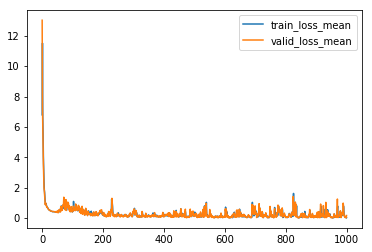

In [28]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss_mean, label='train_loss_mean')
mplot.plot(valid_loss_mean, label='valid_loss_mean')
mplot.legend()

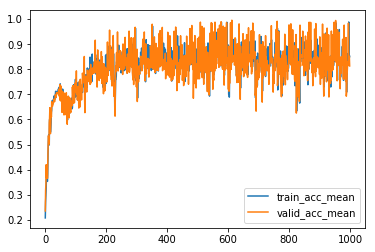

In [29]:
mplot.plot(train_acc_mean, label='train_acc_mean')
mplot.plot(valid_acc_mean, label='valid_acc_mean')
mplot.legend()

In [31]:
with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
    
    # Restoring/loading/uploading the trained and validated model
    saver.restore(sess,'checkpoints/mlp-fnirs-har.ckpt')
    
    # Saving the test loss for every batch/minibtch
    test_loss, test_acc = [], []
    
    # Testing
    for Xinputs, Yindices in get_batches(X=Xtest, Y=Ytest, batch_size=batch_size):
        feed_dict = {model.Xinputs: Xinputs, model.Yindices: Yindices}
        loss, acc = sess.run(fetches=[model.loss, model.acc], feed_dict=feed_dict)
        test_loss.append(loss)
        test_acc.append(acc)
        
    # Printing the test loss
    print('test_loss:', np.mean(test_loss), 'test acc', np.mean(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/mlp-fnirs-har.ckpt
test_loss: 0.16514638 test acc 0.807716


In [ ]:
# INFO:tensorflow:Restoring parameters from checkpoints/mlp-fnirs-har.ckpt
# test_loss: 0.16514638 test acc 0.807716